In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from downcast import reduce
import calmap
import warnings
import kaleido
from plotly.io import to_image
from IPython.display import Image
import pickle
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
#Data Overview 
#3 ficheiros de dados
prices = pd.read_csv('../data/raw/item_prices.csv')
sales = pd.read_csv('../data/raw/item_sales.csv')
calendar = pd.read_csv('../data/raw/daily_calendar_with_events.csv')

print("Dimensões do dataset de vendas:", sales.shape)
print("Dimensões do dataset de preços:", prices.shape)
print("Dimensões do dataset de eventos:", calendar.shape)

Dimensões do dataset de vendas: (30490, 1920)
Dimensões do dataset de preços: (6965706, 5)
Dimensões do dataset de eventos: (1913, 5)


In [4]:
# prices = pd.read_csv('../data/raw/item_prices.csv')
# prices.to_pickle('../data/processed/item_prices.pkl') 
# sales = pd.read_csv('../data/raw/item_sales.csv')
# sales.to_pickle('../data/processed/item_sales.pkl') 
# calendar = pd.read_csv('../data/raw/daily_calendar_with_events.csv')
# calendar.to_pickle('../data/processed/daily_calendar_with_events.pkl') 

prices = pd.read_pickle('../data/processed/item_prices.pkl')
sales = pd.read_pickle('../data/processed/item_sales.pkl')
calendar = pd.read_pickle('../data/processed/daily_calendar_with_events.pkl')

In [5]:
sales.head()

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [17]:
prices.head()

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858


In [15]:
calendar.head()

,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN
2,2011-01-31,Monday,3,d_3,NaN
3,2011-02-01,Tuesday,4,d_4,NaN
4,2011-02-02,Wednesday,5,d_5,NaN


In [10]:
print('O número de eventos são:', len(calendar['event'].unique()))
print('Os eventos são', calendar['event'].unique())

O número de eventos são: 6
Os eventos são [nan, 'SuperBowl', 'Ramadan starts', 'Thanksgiving', 'NewYear', 'Easter']


### Observações

> Sales: Está incluído todos id's dos items, como também a categoria, departamento, loja , região e uma coluna de vendas para cada dia desde 2011-01-29 até 2016-04-24 (1913 dias)

> Prices: Têm os preços de venda dos items, como a respetivo código da loja e uma coluna com o ano_semana

> Calendar: Tem features das datas. É apresentado uma coluna event que denomina a presença de um determinado evento no dia ou não. No total existem 4 eventos.

In [12]:
#Informações acerca dos dados

print('Nº de items:',len(sales['id'].unique()))
print('Nº de departamentos:',len(sales['department'].unique()))

print('Nº de categorias:',len(sales['category'].unique()))
print('Nº de lojas:',len(sales['store'].unique()))
print('Nº de regiões:',len(sales['region'].unique()))

Nº de items: 30490
Nº de departamentos: 7
Nº de categorias: 3
Nº de lojas: 10
Nº de regiões: 3


### Observações

> - As regiões são: **New York, Boston e Philadelphia.**
> - As lojas são: **Greenwich_Village, Harlem, Tribeca, Brooklyn, South_End, Roxbury, Back_Bay, Midtown_Village, Yorktown e Queen_Village.**
> - As categorias são: **ACCESORIES, HOME_&_GARDEN e SUPERMARKET.**
> - Os departamentos são: **ACCESORIES_1, ACCESORIES_2, HOME_&_GARDEN_1, HOME_&_GARDEN_2, SUPERMARKET_1, SUPERMARKET_2 e SUPERMARKET_3.**

### What is downcast Python?
> This package is used the reduce the dataframe size without affecting the values. It find the max and min value in dataframe columns, based on these values it downcast the datatypes of that columns"

 > é uma tecnica para reduzir o tamanho dos dataframes. Basicamente o que ele faz, é para cada int/float de uma coluna, ele verifica o valor minímo e máximo e atribui um novo datatype com a menor storage possivel e para features categóricas ele altera o seu datatype de object para category.

In [35]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)

sales = pd.read_pickle("../data/processed/item_sales.pkl")
prices = pd.read_pickle("../data/processed/item_prices.pkl")
cal = pd.read_pickle("../data/processed/daily_calendar_with_events.pkl")

sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)

In [36]:
#Getting file size in MB before downcasting
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)

#Downcasting the dataframes
sales = reduce(sales)
prices = reduce(prices)
cal = reduce(calendar)

#Getting size after Downcasting
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)

In [37]:
prices.to_pickle('../data/processed/item_prices.pkl')
sales.to_pickle('../data/processed/item_sales.pkl') 
cal.to_pickle('../data/processed/daily_calendar_with_events.pkl') 

In [38]:
print("The size of sales (in MB) before/after downcasting: ",sales_bd,'/',sales_ad)
print("The size of prices (in MB) before/after downcasting: ",prices_bd,'/',prices_ad)
print("The size of cal (in MB) before/after downcasting: ",cal_bd,'/',cal_ad)

The size of sales (in MB) before/after downcasting:  446.6 / 95.2
The size of prices (in MB) before/after downcasting:  265.7 / 66.5
The size of cal (in MB) before/after downcasting:  0.1 / 0.1


In [39]:
dic = {'DataFrame':['sales','prices','cal'],
       'Before downcasting':[sales_bd,prices_bd,cal_bd],
       'After downcasting':[sales_ad,prices_ad,cal_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

Como se pode constatar, os dataframes prices e sales ficaram reduzidos, isto, uma vez que os 1913 colunas int ficaram reduzidos para o menor datatype.

# EDA - Exploratory Data Analisys

In [6]:
d_cols = [i for i in sales.columns if 'd_' in i]

In [7]:
sales.head()

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Analise de Itens

In [18]:
sales.groupby(['id']).head(1000)

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,2,...,2,0,0,0,0,0,1,0,0,1
30486,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,6,0,...,2,1,0,2,0,1,0,0,1,0
30488,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [46]:
sales_melted = sales.melt(id_vars=['id', 'item', 'category', 'department', 'store_code', 'region'], value_vars=[i for i in sales if i.startswith('d_')], var_name=['d'], value_name='sales')
top_3_sales = sales_melted.groupby(['id', 'item']).sum().reset_index().sort_values(by=['sales'],ascending=False)[:3]
# sales_dt = sales.loc[sales['id'] == 'ACCESORIES_1_004_NYC_1'].set_index('id')[d_cols].T

# fig = px.line(sales_dt, title = 'ACCESORIES_1_004_NYC_1 sales by "d" number')
# fig.show()

In [94]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['year'] = calendar['date'].dt.year.apply(int)
calendar['month'] = calendar['date'].dt.month.apply(int)
calendar['day'] = calendar['date'].dt.day.apply(int)

### Top 3 Tendencias dos Itens com mais vendas

In [96]:
examples = []

example1 = sales.loc[sales['id'] == top_3_sales.iloc[0]['id']][d_cols].T
example1 = example1.rename(columns={8412:top_3_sales.iloc[0]['item']}) # Name it correctly
example1 = example1.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example1 = example1.merge(calendar, how='left', validate='1:1')

examples.append(example1)

example2 = sales.loc[sales['id'] == top_3_sales.iloc[1]['id']][d_cols].T
example2 = example2.rename(columns={18055:top_3_sales.iloc[1]['item']}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(calendar, how='left', validate='1:1')

examples.append(example2)

example3 = sales.loc[sales['id'] == top_3_sales.iloc[2]['id']][d_cols].T
example3 = example3.rename(columns={21104:top_3_sales.iloc[2]['item']}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar, how='left', validate='1:1')

examples.append(example3)


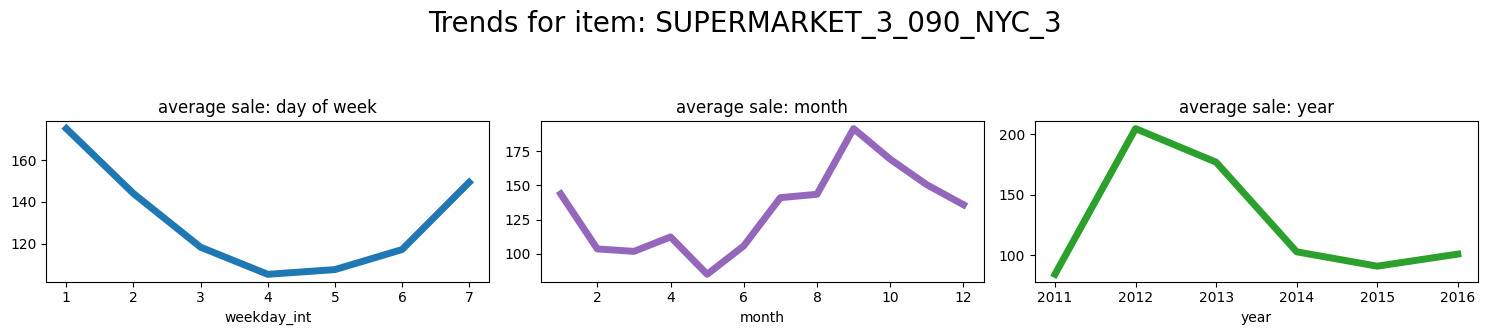

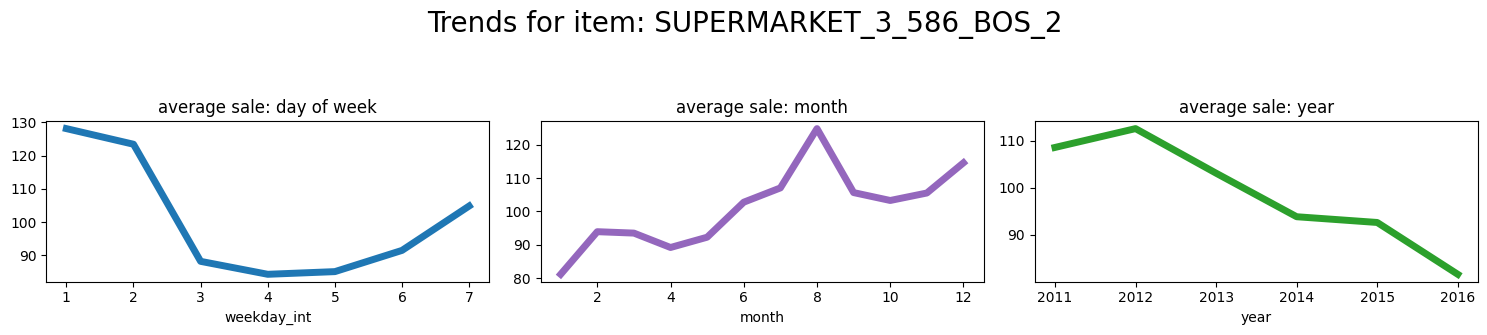

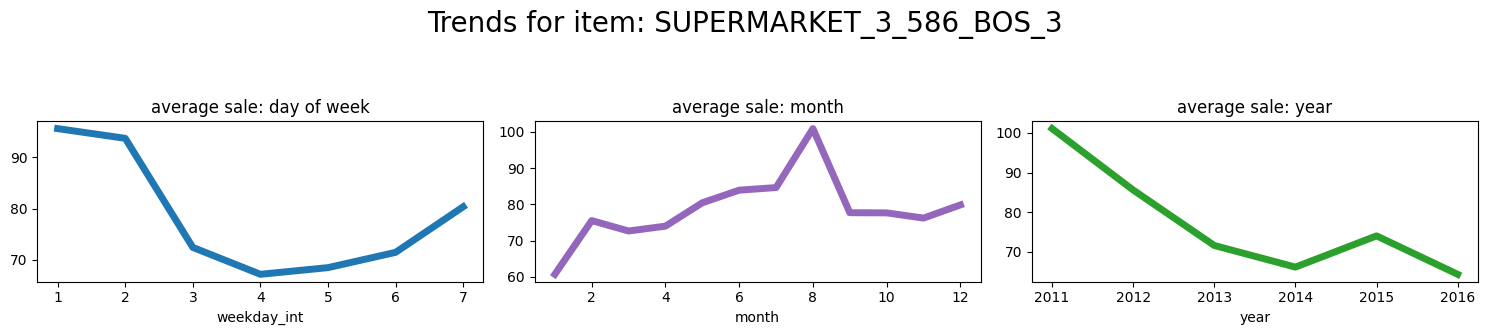

In [117]:
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    name = top_3_sales.iloc[i]['item']
    id = top_3_sales.iloc[i]['id']

    examples[i].groupby('weekday_int').mean()[name].plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)

    examples[i].groupby('month').mean()[name].plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
              ax=ax2)

    examples[i].groupby('year').mean()[name].plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)

    fig.suptitle(f'Trends for item: {id}',
                 size=20,
                 y=1.1)
                 
    plt.tight_layout()
    plt.show()

In [119]:
twenty_examples = sales.sample(20, random_state=529).set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
    left_index=True,
    right_index=True,
    validate='1:1').set_index('date')

### Exibindo as vendas de 20 Itens aleatórios

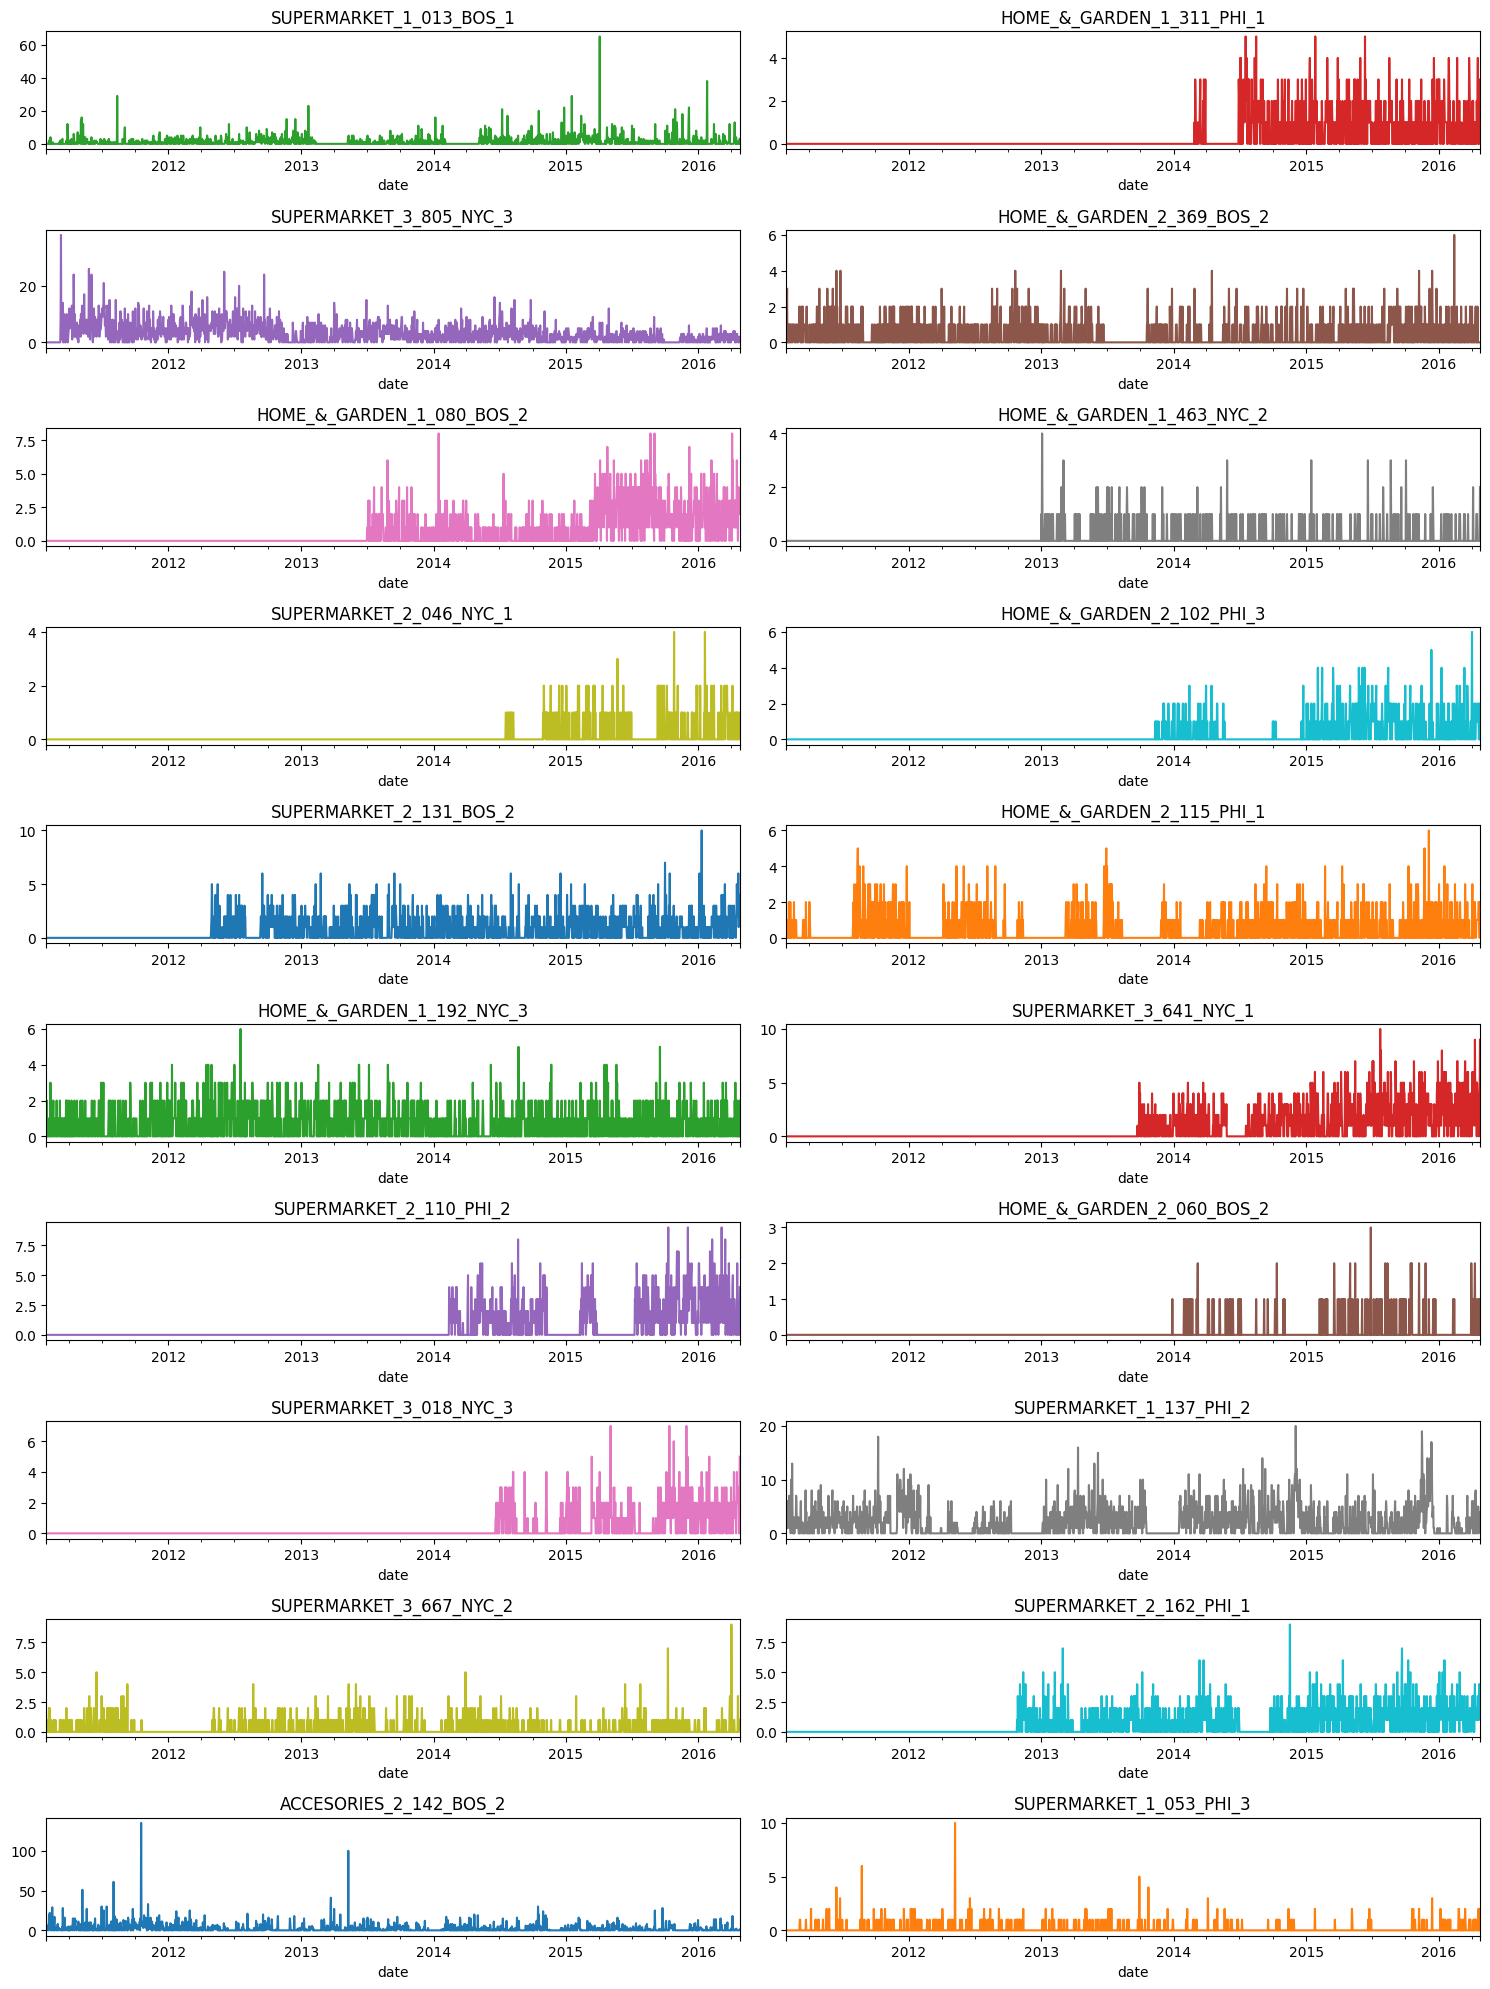

In [121]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

### Todas as vendas agregadas

Vamos ver agora o gráfico das séries com todos os valores agregados de todos os items , lojas, categorias e respetivas unidades vendidas (sales)

In [15]:

sales_df = sales[d_cols]

total_sales = list(sales_df.sum(axis = 0)) 

min_date = calendar['date'].min()
max_date = calendar['date'].max()

date_list = [d for d in pd.date_range(start = min_date, end = max_date)]
agg_sales = pd.DataFrame({'date' : date_list,'sales' : total_sales})

fig = px.line(agg_sales, x='date', y='sales', title = 'Todas as vendas agregadas')

for ser in fig['data']:
    ser['text']= [d.strftime('%Y-%m-%d') for d in agg_sales['date']]
    ser['hovertemplate']='dates=%{text} price=%{y}'

fig.show()

2011-01-29 2016-04-24


### Observações:
> - Depois de um declínio nas vendas em 2011, uma pequena tendência crescente é observada.
> - O número de vendas muito próximo de zero observado em cada ano, corresponde ao dia de Natal dia 25 de Dezembro.
> - Se observarmos o comportamento semanal, verifica-se a presença de sazonalidade/padrão ciclico 

### Vendas mensais por região

In [16]:
sales_df = sales.groupby(['region'])[d_cols].sum()

date_list = [(d.year*100)+d.month for d in pd.date_range(start = min_date, end = max_date)]

agg_sales = pd.DataFrame({'date' : date_list, 'Boston_sales' : sales_df.iloc[0], 'New_York_sales' : sales_df.iloc[1], 'Philadelphia_sales' : sales_df.iloc[2]})
monthly_agg = agg_sales.groupby('date').sum()
monthly_agg = monthly_agg.iloc[1:]

monthly_dates = [d for d in pd.date_range(start = min_date, end = max_date, freq = 'MS')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_dates, y= monthly_agg['Boston_sales'],
                    mode='lines',
                    name='Boston'))
fig.add_trace(go.Scatter(x=monthly_dates, y=monthly_agg['New_York_sales'],
                    mode='lines',
                    name='New York'))
fig.add_trace(go.Scatter(x=monthly_dates, y=monthly_agg['Philadelphia_sales'],
                    mode='lines', name='Philadelphia'))

fig.update_layout(title='Monthly Aggregated Sales per Region',
                   xaxis_title='Time',
                   yaxis_title='Sales')
fig.show()

### Observações:

> - Comparando as vendas mensais das respetivas regiões, constata-se que no período apresentado, New York apresentou uma performance superior à de Boston e de Philadelphia.

> - Verifica-se também que o comportamento das vendas mensais de Boston e Philadelphia é muito semelhante, contudo apesar de inicialmente(2011) Boston apresentar um nível de vendas mensais superior ao de Philadelphia, este termina(2016) com uma pior performance em comparação com o de Philadelphia.

In [110]:
sales.head()

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Tendencia de vendas por loja

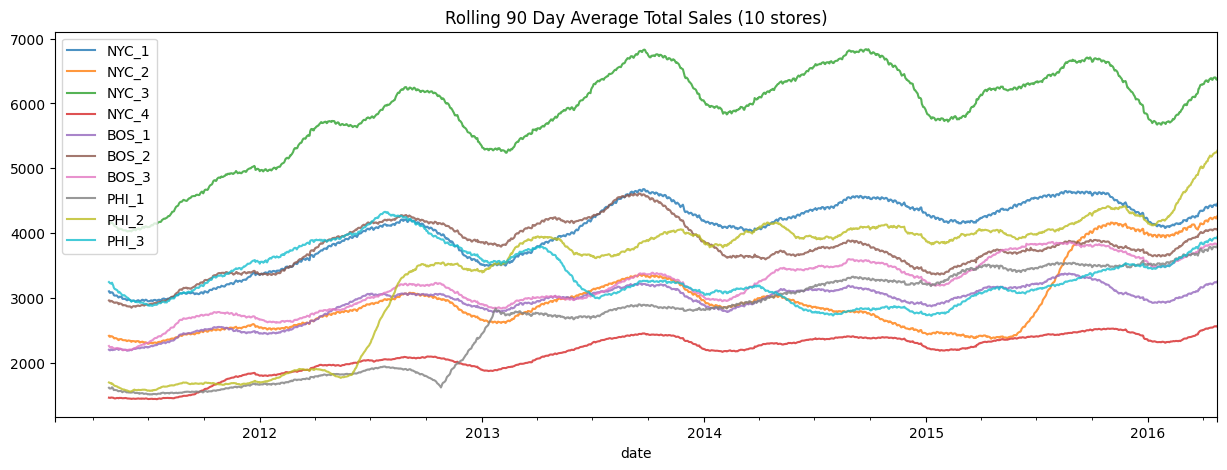

In [123]:
past_sales = sales.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
    left_index=True,
    right_index=True,
    validate='1:1').set_index('date')

store_list = sales['store_code'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(15, 5), alpha=0.8, title='Rolling 90 Day Average Total Sales (10 stores)')

plt.legend(store_list)
plt.show()

### Total de vendas por lojas (Ordernado de forma Ascendente)

In [17]:
sales_df = sales.groupby(['store_code'])[d_cols].sum()
store_sales = sales_df.sum(axis = 1).sort_values(ascending=False)
bar_plot = pd.DataFrame({'stores':store_sales.index, 'sales':store_sales.values})
fig = px.bar(bar_plot, x='stores', y='sales', color = 'stores', title = 'Overall Sales per Store')
fig.show()

### Observações

- COMPLETAR

### Média Movel de Vendas por Loja - Boston

In [19]:
dates = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = min_date, end = max_date)]

past_sales = sales.set_index('id')[d_cols].T

cols = [i for i in sales['store_code'].unique() if i.startswith('BOS_')]

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Moving Average Sales of stores - Boston")

['BOS_1', 'BOS_2', 'BOS_3']


Observaçoes: fazer ainda

### Média Movel de Vendas por Loja - New York

In [20]:
cols = [i for i in sales['store_code'].unique() if i.startswith('NYC_')]

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales of stores - New York")

Observaçoes: Fazer

### Média Movel de Vendas por Loja - Philadelphia

In [21]:
cols = [i for i in sales['store_code'].unique() if i.startswith('PHI_')]

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales of stores in Philadelphia")

Observações: Fazer ainda

### Total de Vendas por Categoria (Ordernado de forma Ascendente)
As categorias são ACCESORIES, HOME_&_GARDEN e SUPERMARKET.

In [22]:
sales_df = sales.groupby(['category'])[d_cols].sum()
cat_sales = sales_df.sum(axis = 1).sort_values(ascending=False)
bar_plot = pd.DataFrame({'categories':cat_sales.index, 'sales':cat_sales.values})
fig = px.bar(bar_plot, x='categories', y='sales', color = 'categories')
fig.show()

Observações: fazer

### Total de Vendas das Categorias por Departamento 

In [24]:
sales['department'].unique()

array(['ACCESORIES_1', 'ACCESORIES_2', 'HOME_&_GARDEN_1',
       'HOME_&_GARDEN_2', 'SUPERMARKET_1', 'SUPERMARKET_2',
       'SUPERMARKET_3'], dtype=object)

In [26]:
fig = make_subplots(rows = 1,cols = 3,subplot_titles=('ACCESORIES', 'HOME_&_GARDEN', 'SUPERMARKET'),shared_yaxes = True)

depts = [[i for i in sales['department'].unique() if i.startswith('ACCESORIES_')],
    [i for i in sales['department'].unique() if i.startswith('HOME_&_GARDEN_')],
    [i for i in sales['department'].unique() if i.startswith('SUPERMARKET_')]]

dates = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = min_date, end = max_date)]

past_sales = sales.set_index('id')[d_cols].T

for i in range(len(depts)):
    cols = depts[i]
    for s in cols:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Scatter(x=dates, y=data, name=s),row = 1,col = i+1)
    
fig.update_layout(yaxis_title="Sales", title = 'Sales of categories per department')

### Observações

> - A categoria **SUPERMARKET** é o que mais vende em seguida **HOME_&_GARDEN** e logo depois **ACCESORIES**, este fato se dá pois produtos desta categoria são mais essenciais do que os outros.
> - Dentro da categoria **SUPERMARKET** é nitido que o departamento **SUPERMARKET_3** está com uma grande quantidade de vendas o que impulsiona a categoria e o **SUPERMARKET_2** está sofrendo um aumento nas vendas
> - Dentro da categoria **HOME_&_GARDEN** vemos uma tendencia de crescimento no departamento **HOME_&_GARDEN_1** em contra partida **HOME_&_GARDEN_2** permanece com uma quantidade de vendas estavel
> - Dentro da categoria **ACCESORIES** vemos que o comportamento dos departamentos **ACCESORIES_1** e **ACCESORIES_2** estão estaveis

In [1]:
calendar_without_na = calendar.replace(to_replace=np.nan, value='NO_EVENT')
calendar_without_na['event'].unique()

NameError: name 'calendar' is not defined

### Média de Vendas em dias de Evento vs Não Evento

In [33]:
calendar = calendar_without_na.iloc[:1913]
d_no_event = list(calendar[calendar['event'] == 'NO_EVENT']['d'])
d_event = list(calendar[calendar['event'] != 'NO_EVENT']['d'])

sales_df = sales.groupby(['department']).sum()

no_mean = []
eve_mean = []

depts = sales['department'].unique()

for i in range(len(depts)):
    no_mean.append(sales_df[d_no_event].iloc[i].mean())
    eve_mean.append(sales_df[d_event].iloc[i].mean())

fig = go.Figure(data=[
    go.Bar(name='No Event', x=depts, y = no_mean),
    go.Bar(name='Event', x=depts, y = eve_mean)
])

fig.update_layout(barmode='group',title = 'Average sales on Event vs Non-Event days')
fig.show()
# img_bytes = fig.to_image(format="png")
# Image(img_bytes)

### Observações

> - A venda média em dias sem evento é um pouco maior que a venda média em dias com evento para todas as categorias com execessão do **SUPERMARKET_3** que demonstra que no dia com evento tem uma pequena elevação nas vendas